In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

%load_ext lab_black

In [2]:
score = pd.read_csv("/Users/emmausds/j40/data_pipeline/data/score/csv/full/usa.csv")

/usr/local/Cellar/jupyterlab/3.2.8/libexec/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3251: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Summary

Counties with persistent poverty overwhelmingly appear in CJEST's disadvantaged communities list. Of the 594 counties in the persistent poverty list, 568 (>95%) contain at least one census tract that CJEST identifies as a disadvantaged community, 6 counties do not appear in CJEST's data (Tribal Nations and some island territories), and only 20 (3%) do not contain at least one census tract identified as disadvantaged. Moreover, the majority of the population in counties with persistent poverty also lives within census tracts identified by CJEST. We will continue to investigate the 20 counties that CJEST does not identify as disadvantaged. 

### Reading and checking data

In [2]:
persistent_poverty_counties = pd.read_excel(
    "/Users/emmausds/Downloads/FY2021_PPCs.xlsx", "FY21 PPCs"
)

In [3]:
persistent_poverty_counties["FIPS_merge"] = (
    persistent_poverty_counties["FIPS"].map(str).str.zfill(5)
)

# checking that fips codes were properly converted
persistent_poverty_counties["FIPS_merge"].sort_values(ascending=True).head(2)

0    01005
1    01007
Name: FIPS_merge, dtype: object

In [4]:
score_def_from_beta = pd.read_csv(
    "/Users/emmausds/Desktop/Screening_Tool_Data/communities-2022-01-19-0351.csv",
    usecols=[
        "GEOID10_TRACT",
        "County Name",
        "Total threshold criteria exceeded",
        "Identified as disadvantaged (v0.1)",
        "Total population",
    ],
    dtype={"Identified as disadvantaged (v0.1)": bool},
)

In [5]:
score_def_from_beta["FIPS_merge"] = score_def_from_beta["GEOID10_TRACT"].apply(
    lambda x: x.strip('"')[:5]
)

# checking that fips codes were properly converted
score_def_from_beta["FIPS_merge"].sort_values(ascending=True).head(2)

44162    01001
44130    01001
Name: FIPS_merge, dtype: object

In [6]:
# checking the unit of the data
persistent_poverty_FIPS = persistent_poverty_counties["FIPS_merge"].unique()
len(persistent_poverty_FIPS), persistent_poverty_counties.shape

(595, (595, 4))

In [7]:
# full outer merge to check differences in datasets
joined_data_full = persistent_poverty_counties.merge(
    score_def_from_beta,
    how="outer",
    indicator=True,
    left_on="FIPS_merge",
    right_on="FIPS_merge",
)

In [8]:
joined_data_full.groupby("_merge")["FIPS_merge"].nunique()

_merge
left_only        7
right_only    2641
both           588
Name: FIPS_merge, dtype: int64

In [9]:
# We do not have AS and Territories right now in the downloadable file
joined_data_full[joined_data_full["_merge"] == "left_only"]

,FIPS,State,County,FIPS_merge,GEOID10_TRACT,County Name,Total threshold criteria exceeded,Identified as disadvantaged (v0.1),Total population,_merge
159,2158.0,AK,Kusilvak Census Area,02158,NaN,NaN,NaN,NaN,NaN,left_only
2224,28000.0,MS,"Mississippi, total",28000,NaN,NaN,NaN,NaN,NaN,left_only
4131,46102.0,SD,Oglala Lakota County,46102,NaN,NaN,NaN,NaN,NaN,left_only
5218,60010.0,AS,"Eastern District, American Samoa",60010,NaN,NaN,NaN,NaN,NaN,left_only
5219,60020.0,AS,"Manu'a District, American Samoa",60020,NaN,NaN,NaN,NaN,NaN,left_only
5220,60030.0,AS,"Rose Island, American Samoa",60030,NaN,NaN,NaN,NaN,NaN,left_only
5221,60050.0,AS,"Western District, American Samoa",60050,NaN,NaN,NaN,NaN,NaN,left_only


In [10]:
# all but the "MS total" show up in both, makes me think this is okay
joined_data_full[joined_data_full["State"] == "MS"]["_merge"].value_counts()

both          374
left_only       1
right_only      0
Name: _merge, dtype: int64

In [11]:
# just to get a sense -- if we limit to just counties in common
joined_data_full[joined_data_full["_merge"] == "both"].groupby("FIPS_merge")[
    "Identified as disadvantaged (v0.1)"
].max().mean()

0.9659863945578231

In [12]:
joined_data_full[
    "Contains at least one tract that has been identified as disadvantaged (v0.1)"
] = joined_data_full.groupby("FIPS_merge")[
    "Identified as disadvantaged (v0.1)"
].transform(
    max
)

### Output CSV

In [13]:
# As a note -- the vast majority of counties have at least one tract identified as disadvantaged
# So I think having "population share" in our back pockets makes sense?
score_def_from_beta.groupby("County Name")[
    "Identified as disadvantaged (v0.1)"
].sum().clip(upper=1).value_counts()

1    1565
0     390
Name: Identified as disadvantaged (v0.1), dtype: int64

In [14]:
score_def_from_beta["County Name"].nunique()

1955

In [15]:
score_def_from_beta.groupby("County Name")[
    "Identified as disadvantaged (v0.1)"
].mean().describe()

count    1955.000000
mean        0.359707
std         0.313686
min         0.000000
25%         0.087161
50%         0.300000
75%         0.555556
max         1.000000
Name: Identified as disadvantaged (v0.1), dtype: float64

In [16]:
# Output
## There's a lot of chaining here, sorry...

output_frame_at_least_one_tract = (
    (
        joined_data_full[joined_data_full["_merge"].isin(["left_only", "both"])][
            [
                "FIPS_merge",
                "State",
                "County",
                "Contains at least one tract that has been identified as disadvantaged (v0.1)",
            ]
        ]
        # only keep one row per county
        .drop_duplicates()
        # rename FIPs string
        .rename(columns={"FIPS_merge": "FIPS"})
    )
    # Sort by TRUE/FALSE/NAN so the excel is pretty
    .sort_values(
        by="Contains at least one tract that has been identified as disadvantaged (v0.1)",
        ascending=False,
    )
    # Fill NaNs with a note
    .fillna("Not included in CJEST tool (v0.1)")
)

output_frame_at_least_one_tract[
    "Contains at least one tract that has been identified as disadvantaged (v0.1)"
].value_counts(dropna=False, normalize=False)

True                                 568
False                                 20
Not included in CJEST tool (v0.1)      7
Name: Contains at least one tract that has been identified as disadvantaged (v0.1), dtype: int64

In [17]:
# Super annoying -- I want excel to read in as a string, and this is an easy way :shrug:
output_frame_at_least_one_tract["FIPS"] = output_frame_at_least_one_tract["FIPS"].apply(
    lambda x: f'"{x}"'
)

In [18]:
import xlsxwriter

excel_writer = pd.ExcelWriter("./CJEST_PPCs.xlsx")
output_frame_at_least_one_tract.to_excel(
    excel_writer, sheet_name="PPCs in CJEST DACs", index=False
)
workbook = excel_writer.book
worksheet = excel_writer.sheets["PPCs in CJEST DACs"]

# Add a header format.
header_format = workbook.add_format(
    {
        "bold": True,
        "text_wrap": True,
        "valign": "vcenter",
        "align": "center",
        "border": 0,
    }
)

# Write the column headers with the defined format.
for i, col_string in enumerate(output_frame_at_least_one_tract.columns.values):
    worksheet.write(0, i, col_string, header_format)

excel_writer.sheets["PPCs in CJEST DACs"].set_column(2, 2, 17)
excel_writer.sheets["PPCs in CJEST DACs"].set_column(3, 3, 25)

excel_writer.save()

In [19]:
# export to excel


excel_writer = pd.ExcelWriter("./test_output.xlsx")
output_frame_at_least_one_tract.to_excel(
    excel_writer, sheet_name="PPCs in CJEST DACs", index=False
)

cell_format = workbook.add_format()
cell_format.set_text_wrap()

excel_writer.sheets["PPCs in CJEST DACs"].set_column(2, 2, 18, cell_format)
excel_writer.sheets["PPCs in CJEST DACs"].set_column(3, 3, 30, cell_format)
excel_writer.save()

### Scratch

Some more analysis probably just for us that inspects what populations get included 

In [20]:
joined_data_inner = joined_data_full[joined_data_full["_merge"] == "both"].copy(
    deep=True
)

In [21]:
joined_data_inner[
    joined_data_inner[
        "Contains at least one tract that has been identified as disadvantaged (v0.1)"
    ]
    == 0
][
    ["County", "State"]
].drop_duplicates()  # ["Total threshold criteria exceeded"].value_counts()

,County,State
1018,Montgomery County,GA
1054,Tattnall County,GA
1112,Kalawao County,HI
1114,Madison County,ID
2793,Golden Valley County,MT
2794,Musselshell County,MT
2804,Keya Paha County,NE
3470,Sheridan County,ND
3532,Harmon County,OK
4118,Clay County,SD


/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Share of population identified across FIPS', ylabel='Density'>

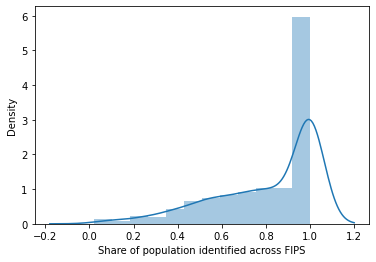

In [22]:
population_shares = (
    (
        joined_data_inner.groupby(
            ["FIPS_merge", "County", "State", "Identified as disadvantaged (v0.1)"]
        )["Total population"]
        .sum()
        .groupby("FIPS_merge")
        .transform(lambda x: x / x.sum())
    )
    .rename("Share of population identified across FIPS")
    .reset_index()
)

disadv_counties_by_population_in_tract = population_shares[
    population_shares["Identified as disadvantaged (v0.1)"]
].sort_values(by="Share of population identified across FIPS", ascending=False)


sns.distplot(
    disadv_counties_by_population_in_tract["Share of population identified across FIPS"]
)

This just shows that we are in fact pulling heavily from disadvantaged communities

In [28]:
joined_data_inner[joined_data_inner["Total population"].isna()]

,FIPS,State,County,FIPS_merge,GEOID10_TRACT,County Name,Total threshold criteria exceeded,Identified as disadvantaged (v0.1),Total population,_merge,Contains at least one tract that has been identified as disadvantaged (v0.1)
5222,69085.0,MP,"Northern Islands Municipality, Commonwealth of...",69085,"""69085950100""",NaN,0.0,False,NaN,both,False
5223,69100.0,MP,"Rota Municipality, Commonwealth of the Norther...",69100,"""69100950100""",NaN,1.0,True,NaN,both,True
5224,69100.0,MP,"Rota Municipality, Commonwealth of the Norther...",69100,"""69100990000""",NaN,0.0,False,NaN,both,True
5225,69110.0,MP,"Saipan Municipality, Commonwealth of the North...",69110,"""69110000800""",NaN,1.0,True,NaN,both,True
5226,69110.0,MP,"Saipan Municipality, Commonwealth of the North...",69110,"""69110000900""",NaN,3.0,True,NaN,both,True
5227,69110.0,MP,"Saipan Municipality, Commonwealth of the North...",69110,"""69110001600""",NaN,2.0,True,NaN,both,True
5228,69110.0,MP,"Saipan Municipality, Commonwealth of the North...",69110,"""69110001100""",NaN,2.0,True,NaN,both,True
5229,69110.0,MP,"Saipan Municipality, Commonwealth of the North...",69110,"""69110001200""",NaN,3.0,True,NaN,both,True
5230,69110.0,MP,"Saipan Municipality, Commonwealth of the North...",69110,"""69110000500""",NaN,1.0,True,NaN,both,True
5231,69110.0,MP,"Saipan Municipality, Commonwealth of the North...",69110,"""69110001000""",NaN,2.0,True,NaN,both,True


In [23]:
joined_data_inner.groupby("Identified as disadvantaged (v0.1)")[
    "Total population"
].sum() / joined_data_inner["Total population"].sum()

Identified as disadvantaged (v0.1)
False    0.308259
True     0.691741
Name: Total population, dtype: float64

In [24]:
score_def_from_beta.groupby("Identified as disadvantaged (v0.1)")[
    "Total population"
].sum() / score_def_from_beta["Total population"].sum()

Identified as disadvantaged (v0.1)
False    0.714366
True     0.285634
Name: Total population, dtype: float64

In [25]:
just_checking_as_is_missing = pd.read_csv(
    "/Users/emmausds/Desktop/Screening_Tool_Data/communities-2022-01-19-0351.csv",
    usecols=["State/Territory"],
)
(just_checking_as_is_missing["State/Territory"] == "American Samoa").sum()

0